<a href="https://colab.research.google.com/github/rhazem13/MemoryMate/blob/master/Alzheimers_Detection_using_DenseNet169_DeepLearing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORT LIBRARIES**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

 **IMPORT / VIEWING / PREPROCESSING DATASET**

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [03:23<00:00, 40.72s/it]


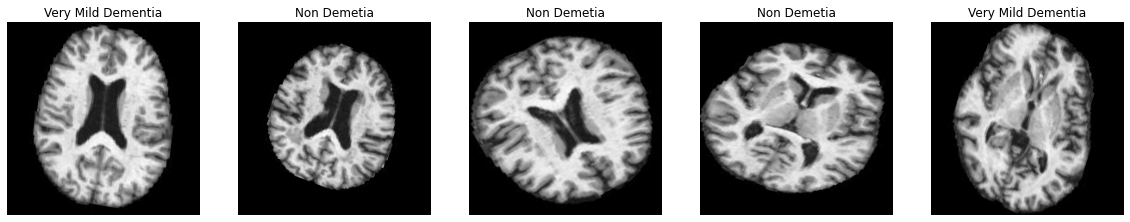

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

**MODEL BUILDING**

In [8]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 2s 0us/step


In [9]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [10]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [11]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [12]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [13]:
# Defining Callbacks

filepath = '/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [14]:
!nvidia-smi

Thu Feb  2 12:01:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |   4532MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import torch
torch.cuda.is_available()

True

In [16]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [17]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 1.3621 - auc: 0.7859 
Epoch 1: val_auc improved from -inf to 0.65467, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
33/33 [==============================] - 1135s 34s/step - loss: 1.3621 - auc: 0.7859 - val_loss: 5.5458 - val_auc: 0.6547
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 1.0947 - auc: 0.8332
Epoch 2: val_auc improved from 0.65467 to 0.75701, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
33/33 [==============================] - 80s 2s/step - loss: 1.0947 - auc: 0.8332 - val_loss: 2.2897 - val_auc: 0.7570
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 0.9804 - auc: 0.8496
Epoch 3: val_auc improved from 0.75701 to 0.78306, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
33/33 [==============================] - 83s 3s/step - loss: 0.9804 - auc: 0.8496 - val_loss: 1.8056 - val_auc: 0.7831


**MODEL EVALUATION**

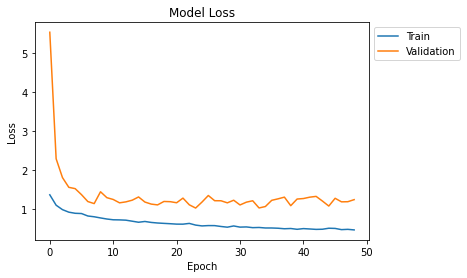

In [18]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

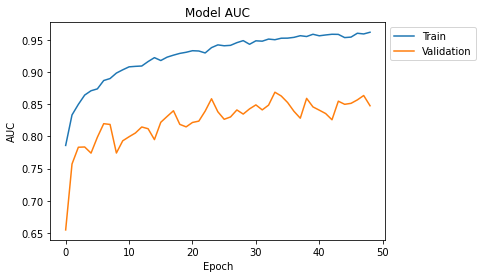

In [19]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [20]:
 #Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [21]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 358s 40s/step - loss: 1.3965 - auc: 0.8513


[1.3964813947677612, 0.8513379096984863]

In [22]:
from numpy import array

1/1 [==============================] - 0s 44ms/step
99.99 % chances are there that the image is NonDemented


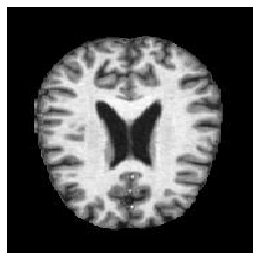

In [23]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is' , idc[np.argmax(model.predict(img))])

1/1 [==============================] - 0s 42ms/step
91.26 % chances are there that the image is MildDemented


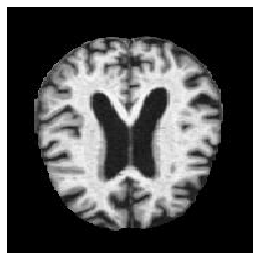

In [24]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is' , idc[np.argmax(model.predict(img))])

1/1 [==============================] - 0s 30ms/step
99.07 % chances are there that the image is ModerateDemented


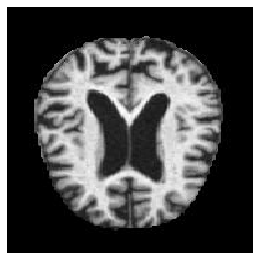

In [25]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
probability = round(np.max(model.predict(img)*100),2)

print(probability, '% chances are there that the image is' , idc[np.argmax(model.predict(img))])

1/1 [==============================] - 0s 30ms/step
94.28 % chances are there that the image is VeryMildDemented


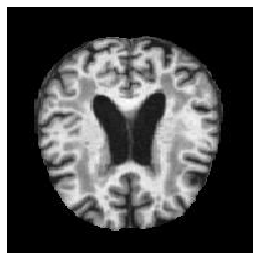

In [29]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Colab Notebooks/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
probability = round(np.max(model.predict(img)*100),2)
print(probability, '% chances are there that the image is' , idc[np.argmax(model.predict(img))])

In [30]:
model.save('/content/drive/MyDrive/Colab Notebooks/AlzhemersModel.h5')

In [31]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/AlzhemersModel.hdf5')